### Data Insights

Load the already cleaned question answer pairs generated.

In [2]:
# Python Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
# Load the QA dataset
qa = pd.read_csv('../src/data/processed/movie_qa.txt', index_col=0)
qa.head()

,question,answer
0,Can we make this quick Roxanne Korrine and An...,Well I thought we would start with pronunciati...
1,Well I thought we would start with pronunciati...,Not the hacking and gagging and spitting part ...
2,Not the hacking and gagging and spitting part ...,Okay then how about we try out some French cui...
3,Okay then how about we try out some French cui...,<EOC>
4,you are asking me out that is so cute what is...,Forget it


#### Response Length

We first look at the how long a typical response is. We start by filtering out End of conversation markers 'EOC'

In [6]:
# Filter out EOC
qa_no_eoc = qa[qa.answer != '<EOC>']['answer']

# Get lengths for each value
resp_len = qa_no_eoc.apply(lambda x: len(str(x).split()))

resp_len.describe()

count    221616.000000
mean         11.083054
std          12.630780
min           0.000000
25%           4.000000
50%           7.000000
75%          14.000000
max         556.000000
Name: answer, dtype: float64

We see that the median response length is 7 words, but the distribution is skewed by presence of extreme outliers. Lets look at the box plot for verification.

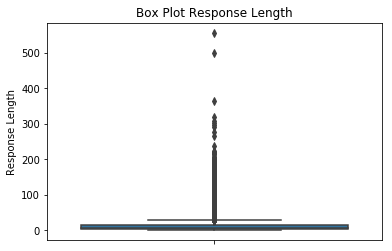

In [7]:
# Box Plot
_ = sns.boxplot(resp_len, orient='v')
_ = plt.ylabel('Response Length')
_ = plt.xlabel('')
_ = plt.title('Box Plot Response Length')

We remove the outliers by using the 1.5 times IQR thumb rule, so we filter out values outside range (2, 30)

In [12]:
filt = np.logical_and(resp_len > 2, resp_len < 30)
resp_len_filt = resp_len[filt]

resp_len_filt.describe()

count    173926.000000
mean          9.990921
std           6.379758
min           3.000000
25%           5.000000
50%           8.000000
75%          13.000000
max          29.000000
Name: answer, dtype: float64

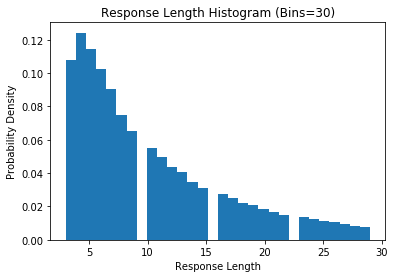

In [14]:
_ = plt.hist(resp_len_filt, density=True, bins=30)
_ = plt.xlabel('Response Length')
_ = plt.ylabel('Probability Density')
_ = plt.title('Response Length Histogram (Bins=30)')

We see that response length goes down exponentially. People prefer brevity in responses over longer sentences. This is an important insight for training batches, as the longer input sequences lead to padding in shorter sequences increasing cpu/memory usage.

#### Conversation Length

Next we look at how long do conversations last. This can be easily inferred by looking at the eoc_markers.

In [21]:
eoc_marks = sorted(list(set(qa.answer.index.values) - set(qa_no_eoc.index.values)))

conv_len_arr = [eoc_marks[0]]
for i in range(len(eoc_marks)-1):
    conv_len_arr.append(eoc_marks[i+1] - eoc_marks[i] - 1)
    
conv_len = pd.Series(conv_len_arr)
conv_len.describe()

count    83097.000000
mean         2.666955
std          2.891798
min          1.000000
25%          1.000000
50%          2.000000
75%          3.000000
max         88.000000
dtype: float64

We again see extreme values in this distribution. 75% of the conversations are less than 3 turns. We again filter for extreme values in range (2,30) and check how many conversations are dropped.

In [24]:
filt = np.logical_and(conv_len > 0, conv_len < 30)
conv_len_filt = conv_len[filt]

conv_len_filt.describe()
print('% kept: {0:.2%}'.format(conv_len_filt.count() / conv_len.count()))

% kept: 99.92%


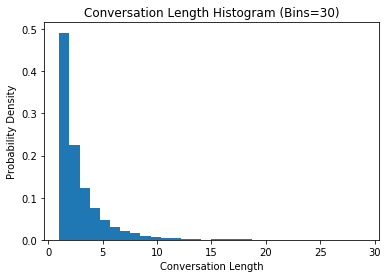

In [25]:
_ = plt.hist(conv_len_filt, density=True, bins=30)
_ = plt.xlabel('Conversation Length')
_ = plt.ylabel('Probability Density')
_ = plt.title('Conversation Length Histogram (Bins=30)')

We see that in naturally occuring conversations, most conversations end in 2-3 turns. This gives us an insight that we can limit the number of turns to some small number, such as 5, for evaluation of the model. 

#### Most common Responses

Next we look at the most common responses generated in the data.

In [43]:
from collections import Counter

resp_cnt = Counter(qa_no_eoc)

resp_cnt.most_common(10)

[('What', 1532),
 ('Yes', 1484),
 ('No', 1423),
 ('Yeah', 1117),
 ('Why', 502),
 ('I do not know', 397),
 ('Okay', 357),
 ('Sure', 277),
 ('Oh', 266),
 ('Thank you', 246)]

We see that most common responses are responses to questions and most act as conversation stoppers (with the exception of 'Why?'). We expect them to see again in the list of dull responses next.

In [41]:
resp_dist = pd.Series([i for i in resp_cnt.values()])
resp_dist.describe()

count    189270.000000
mean          1.170899
std           7.122922
min           1.000000
25%           1.000000
50%           1.000000
75%           1.000000
max        1532.000000
dtype: float64

We see that most responses occur in the corpus only once. This should also result in model predicting unique responses.

#### Dull responses

Identifying dull responses is an important functionality for deciding on rewards in Reinforcement learning module. We look at all the questions that result in end of conversation.

In [45]:
# Questions generating a end of conversation response
qa_dull = qa[qa.answer == '<EOC>']['question']

dull_cnt = Counter(qa_dull)

dull_cnt.most_common(10)

[('No', 360),
 ('Yes', 356),
 ('Yeah', 307),
 ('What', 234),
 ('Okay', 211),
 ('Sure', 154),
 ('I do not know', 145),
 ('Thank you', 136),
 ('Oh', 120),
 ('Right', 104)]

This is again expected as these responses are stop responses that typically end a conversation.